# Comprehensive Missing Values Analysis

**Purpose**: Dedicated analysis of missing data patterns across all datasets to inform imputation strategies for modeling.

**Scope**: This notebook consolidates missing value analysis from existing notebooks and provides comprehensive insights for feature engineering decisions.

## Key Questions Addressed:
1. Which features have critical missing data (>20%) that need special handling?
2. Are there systematic patterns in missing data (MCAR vs MAR vs MNAR)?
3. How do missing values correlate with each other?
4. What are the optimal imputation strategies for each feature type?
5. Should any features be dropped due to excessive missingness?

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Set visualization style
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

# Create plots directory for saving
plots_dir = Path("../reports/figures/missing_values_analysis")
plots_dir.mkdir(parents=True, exist_ok=True)


# Helper function to save plots with consistent formatting
def save_plot(filename, title_for_print=None):
    """Save current matplotlib figure with consistent formatting"""
    plot_path = plots_dir / f"{filename}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches="tight", facecolor="white")
    display_name = title_for_print or filename.replace("_", " ").title()
    print(f"📊 Plot saved: {display_name} -> {plot_path.name}")
    return plot_path


print("📊 Missing Values Analysis - Setup Complete")
print(f"📁 Plots will be saved to: {plots_dir}")
print("=" * 50)

📊 Missing Values Analysis - Setup Complete
📁 Plots will be saved to: ../reports/figures/missing_values_analysis


## 1. Data Loading and Initial Assessment

In [13]:
# Load processed datasets
data_dir = Path("../data/processed/etap2")

print("Loading datasets...")
try:
    listings_df = pd.read_pickle(data_dir / "listings_e2_df.pkl")
    calendar_df = pd.read_pickle(data_dir / "calendar_e2_df.pkl")
    reviews_df = pd.read_pickle(data_dir / "reviews_e2_df.pkl")

    print(f"✅ Listings: {listings_df.shape}")
    print(f"✅ Calendar: {calendar_df.shape}")
    print(f"✅ Reviews: {reviews_df.shape}")

except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure etap2 processed data is available")

print("\n" + "=" * 50)

Loading datasets...
✅ Listings: (47572, 75)
✅ Calendar: (17363102, 5)
✅ Reviews: (953651, 7)



## 2. Overall Missing Data Landscape

In [14]:
def calculate_dataset_missingness(df, name):
    """Calculate comprehensive missing data statistics for a dataset"""
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    missing_pct = (missing_cells / total_cells) * 100

    # Per-column statistics
    col_missing = df.isnull().sum()
    col_missing_pct = (col_missing / len(df)) * 100

    # Missing value summary
    missing_summary = pd.DataFrame(
        {
            "missing_count": col_missing,
            "missing_percentage": col_missing_pct,
            "data_type": df.dtypes,
        }
    )

    # Filter to only columns with missing values
    missing_summary = missing_summary[missing_summary["missing_count"] > 0]
    missing_summary = missing_summary.sort_values("missing_percentage", ascending=False)

    return {
        "name": name,
        "total_cells": total_cells,
        "missing_cells": missing_cells,
        "overall_missing_pct": missing_pct,
        "columns_with_missing": len(missing_summary),
        "total_columns": len(df.columns),
        "missing_summary": missing_summary,
    }


# Calculate for all datasets
datasets = {"Listings": listings_df, "Calendar": calendar_df, "Reviews": reviews_df}

missing_stats = {}
for name, df in datasets.items():
    missing_stats[name] = calculate_dataset_missingness(df, name)

# Summary table
print("📈 OVERALL MISSING DATA LANDSCAPE")
print("=" * 50)

summary_data = []
for name, stats in missing_stats.items():
    summary_data.append(
        {
            "Dataset": name,
            "Rows": f"{datasets[name].shape[0]:,}",
            "Columns": datasets[name].shape[1],
            "Columns w/ Missing": stats["columns_with_missing"],
            "Overall Missing %": f"{stats['overall_missing_pct']:.2f}%",
        }
    )

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("\n" + "=" * 50)

📈 OVERALL MISSING DATA LANDSCAPE
 Dataset       Rows  Columns  Columns w/ Missing Overall Missing %
Listings     47,572       75                  38            13.50%
Calendar 17,363,102        5                   0             0.00%
 Reviews    953,651        7                   2             0.00%



## 3. Critical Features Analysis - Listings Dataset Focus

Since listings is our primary dataset for modeling, we'll focus detailed analysis here.

In [15]:
# Define critical features for modeling
CRITICAL_FEATURES = {
    "size_features": ["accommodates", "bedrooms", "beds", "bathrooms_text"],
    "price_features": ["price"],
    "location_features": ["neighbourhood_cleansed", "latitude", "longitude"],
    "host_features": [
        "host_is_superhost",
        "host_identity_verified",
        "host_response_rate",
        "host_acceptance_rate",
    ],
    "review_features": [
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
        "number_of_reviews",
    ],
    "availability_features": ["minimum_nights", "maximum_nights", "availability_365"],
    "property_features": ["property_type", "room_type", "instant_bookable"],
}

# Flatten to get all critical features
all_critical_features = []
for category, features in CRITICAL_FEATURES.items():
    all_critical_features.extend(features)

# Filter to features that exist in our dataset
available_critical_features = [
    f for f in all_critical_features if f in listings_df.columns
]

print(f"🎯 CRITICAL FEATURES MISSING VALUE ANALYSIS")
print(f"Analyzing {len(available_critical_features)} critical features for modeling")
print("=" * 60)

# Calculate missing values for critical features
critical_missing = []
for feature in available_critical_features:
    missing_count = listings_df[feature].isnull().sum()
    missing_pct = (missing_count / len(listings_df)) * 100
    data_type = str(listings_df[feature].dtype)

    # Determine category
    category = "other"
    for cat, features in CRITICAL_FEATURES.items():
        if feature in features:
            category = cat
            break

    critical_missing.append(
        {
            "feature": feature,
            "category": category,
            "missing_count": missing_count,
            "missing_percentage": missing_pct,
            "data_type": data_type,
            "priority": "HIGH"
            if missing_pct > 20
            else "MEDIUM"
            if missing_pct > 5
            else "LOW",
        }
    )

critical_missing_df = pd.DataFrame(critical_missing)
critical_missing_df = critical_missing_df.sort_values(
    "missing_percentage", ascending=False
)

# Display results by priority
for priority in ["HIGH", "MEDIUM", "LOW"]:
    priority_features = critical_missing_df[critical_missing_df["priority"] == priority]
    if len(priority_features) > 0:
        print(
            f"\n🚨 {priority} PRIORITY FEATURES (Missing >{20 if priority == 'HIGH' else 5 if priority == 'MEDIUM' else 0}%):"
        )
        for _, row in priority_features.iterrows():
            print(
                f"  • {row['feature']:25s} [{row['category']:15s}] {row['missing_percentage']:6.1f}% ({row['missing_count']:,} rows)"
            )

print("\n" + "=" * 60)

🎯 CRITICAL FEATURES MISSING VALUE ANALYSIS
Analyzing 26 critical features for modeling

🚨 HIGH PRIORITY FEATURES (Missing >20%):
  • host_response_rate        [host_features  ]   34.2% (16,267 rows)
  • beds                      [size_features  ]   34.1% (16,236 rows)
  • price                     [price_features ]   34.0% (16,189 rows)
  • host_acceptance_rate      [host_features  ]   28.7% (13,669 rows)
  • review_scores_location    [review_features]   25.8% (12,272 rows)
  • review_scores_value       [review_features]   25.8% (12,271 rows)
  • review_scores_checkin     [review_features]   25.8% (12,271 rows)
  • review_scores_communication [review_features]   25.8% (12,260 rows)
  • review_scores_accuracy    [review_features]   25.8% (12,256 rows)
  • review_scores_cleanliness [review_features]   25.8% (12,253 rows)
  • review_scores_rating      [review_features]   25.7% (12,247 rows)

🚨 MEDIUM PRIORITY FEATURES (Missing >5%):
  • bedrooms                  [size_features  ]   13.1% 

## 4. Missing Data Visualizations

📊 Plot saved: Comprehensive Missing Data Analysis -> 01_comprehensive_missing_data_analysis.png


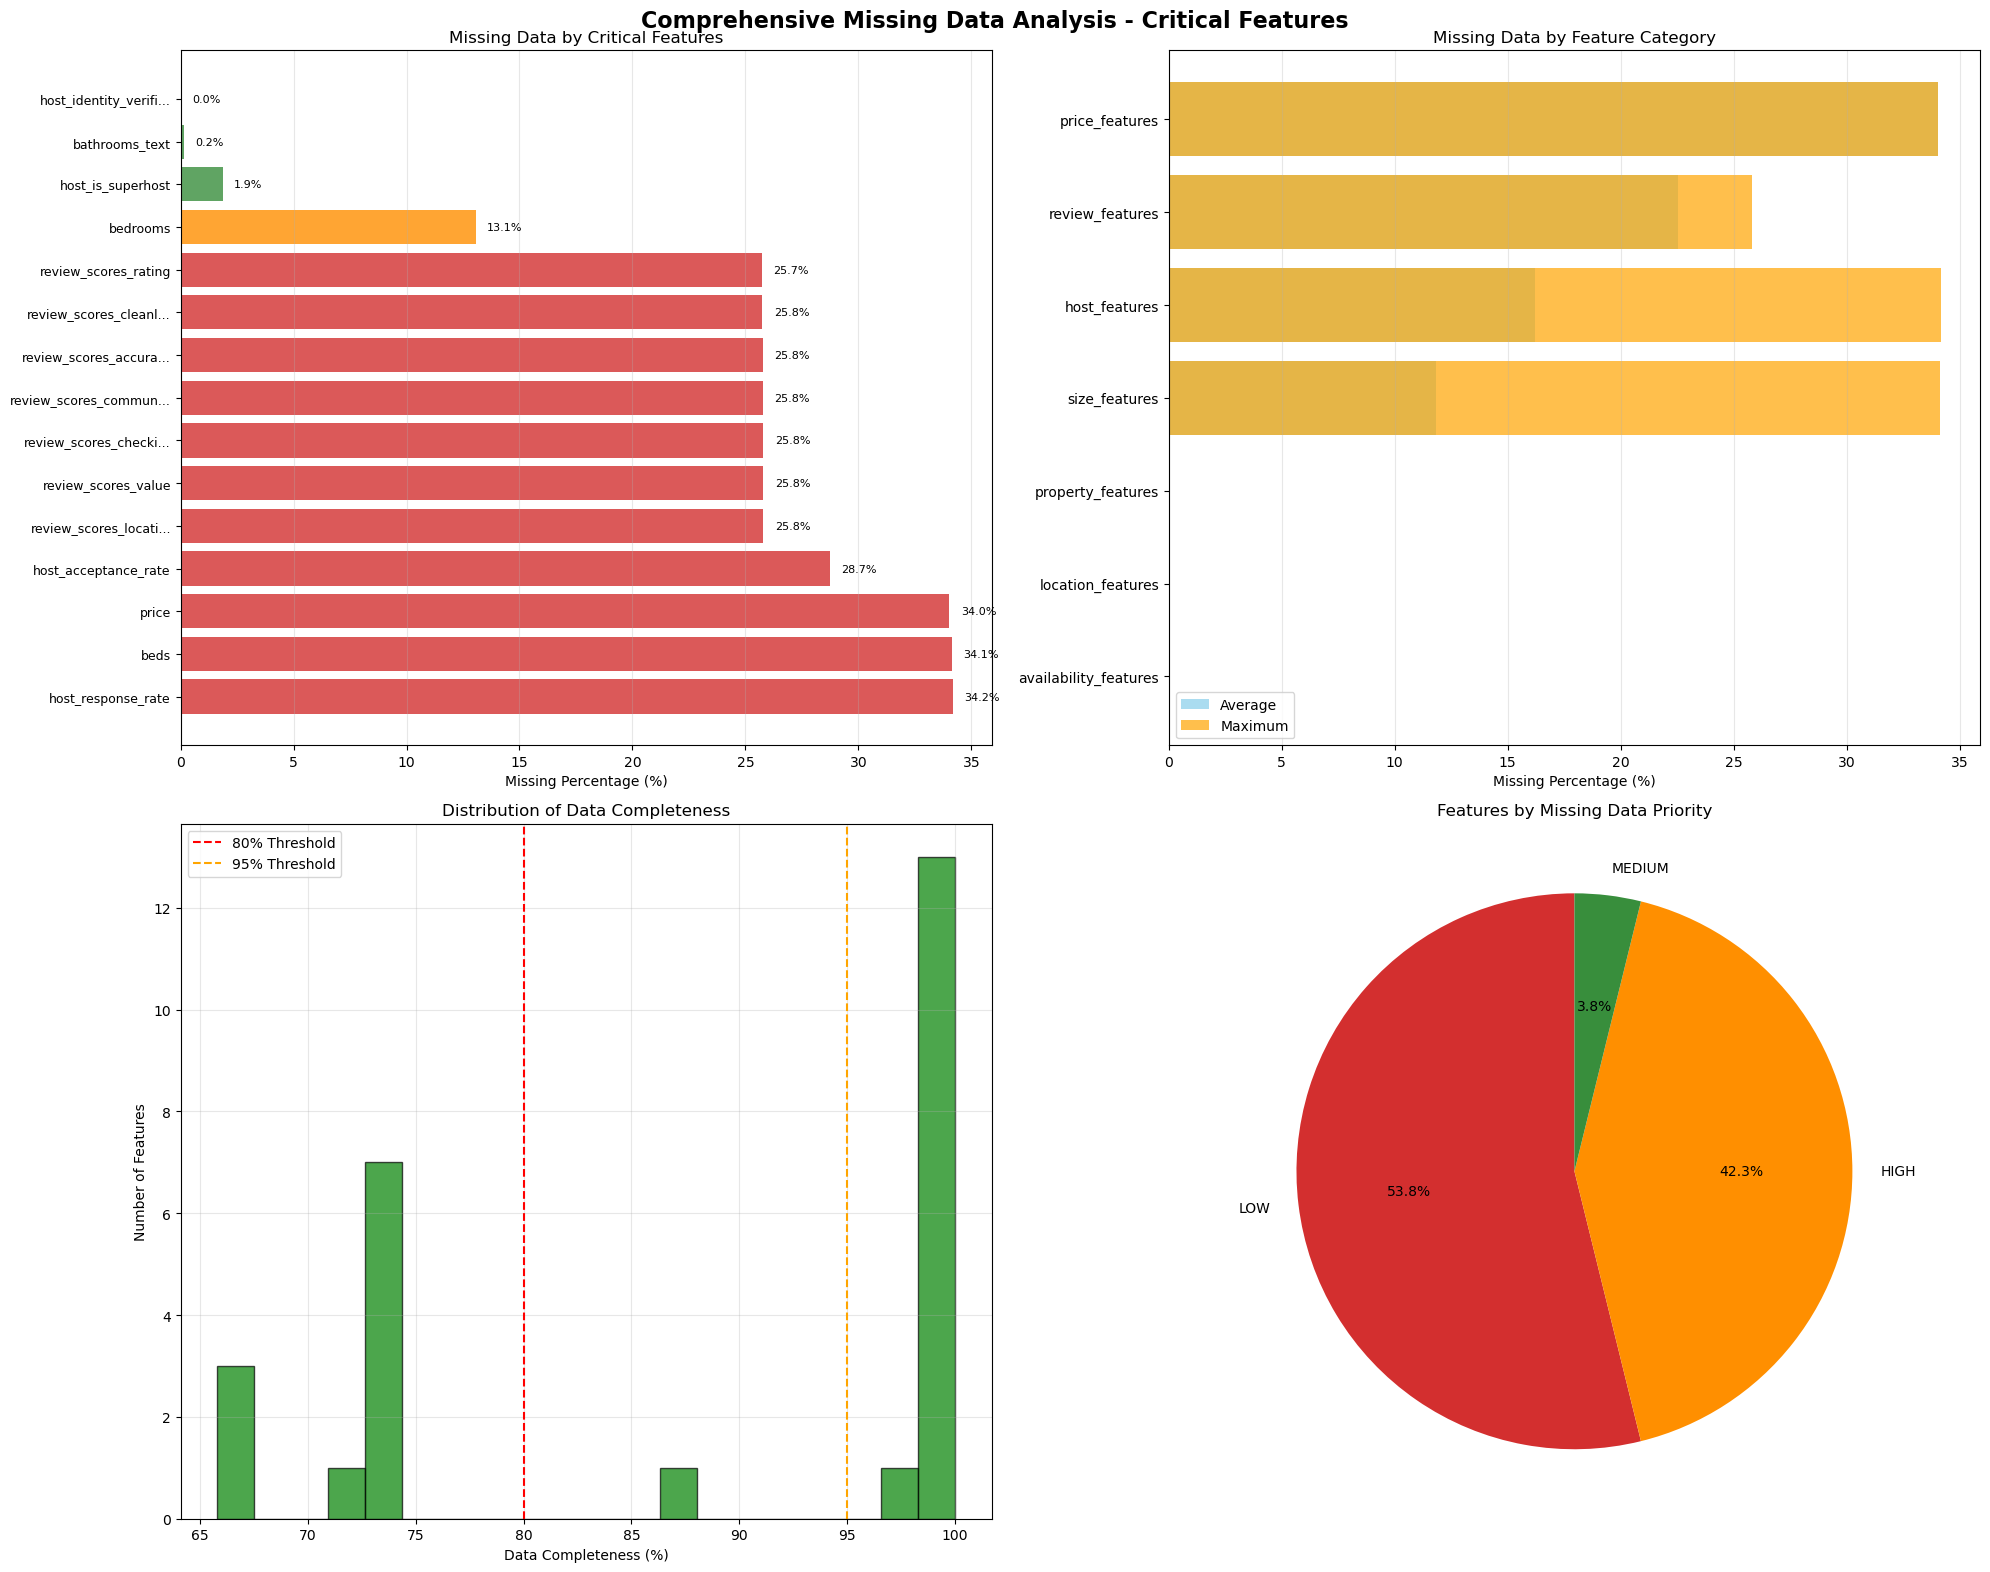


📊 MISSING DATA SUMMARY STATISTICS
Features with >20% missing (HIGH priority): 11
Features with 5-20% missing (MEDIUM priority): 1
Features with <5% missing (LOW priority): 14

Average data completeness: 87.4%
Features with >95% completeness: 14
Features with <80% completeness: 11


In [16]:
# Create comprehensive missing data visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle(
    "Comprehensive Missing Data Analysis - Critical Features",
    fontsize=16,
    fontweight="bold",
)

# 1. Missing percentages bar chart
top_missing = critical_missing_df.head(15)
colors = [
    "#D32F2F" if x > 20 else "#FF8F00" if x > 5 else "#388E3C"
    for x in top_missing["missing_percentage"]
]

bars = axes[0, 0].barh(
    range(len(top_missing)), top_missing["missing_percentage"], color=colors, alpha=0.8
)
axes[0, 0].set_yticks(range(len(top_missing)))
axes[0, 0].set_yticklabels(
    [f"{feat[:20]}..." if len(feat) > 20 else feat for feat in top_missing["feature"]],
    fontsize=9,
)
axes[0, 0].set_xlabel("Missing Percentage (%)")
axes[0, 0].set_title("Missing Data by Critical Features")
axes[0, 0].grid(axis="x", alpha=0.3)

# Add percentage labels
for i, (_, row) in enumerate(top_missing.iterrows()):
    axes[0, 0].text(
        row["missing_percentage"] + 0.5,
        i,
        f"{row['missing_percentage']:.1f}%",
        va="center",
        fontsize=8,
    )

# 2. Missing data by category
category_missing = (
    critical_missing_df.groupby("category")["missing_percentage"]
    .agg(["mean", "max", "count"])
    .reset_index()
)
category_missing = category_missing.sort_values("mean", ascending=True)

x_pos = range(len(category_missing))
axes[0, 1].barh(
    x_pos, category_missing["mean"], alpha=0.7, color="skyblue", label="Average"
)
axes[0, 1].barh(
    x_pos, category_missing["max"], alpha=0.7, color="orange", label="Maximum"
)
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(category_missing["category"])
axes[0, 1].set_xlabel("Missing Percentage (%)")
axes[0, 1].set_title("Missing Data by Feature Category")
axes[0, 1].legend()
axes[0, 1].grid(axis="x", alpha=0.3)

# 3. Data completeness overview
completeness_data = []
for feature in available_critical_features:
    completeness = (
        (len(listings_df) - listings_df[feature].isnull().sum()) / len(listings_df)
    ) * 100
    completeness_data.append(completeness)

axes[1, 0].hist(completeness_data, bins=20, alpha=0.7, color="green", edgecolor="black")
axes[1, 0].set_xlabel("Data Completeness (%)")
axes[1, 0].set_ylabel("Number of Features")
axes[1, 0].set_title("Distribution of Data Completeness")
axes[1, 0].axvline(80, color="red", linestyle="--", label="80% Threshold")
axes[1, 0].axvline(95, color="orange", linestyle="--", label="95% Threshold")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Priority distribution
priority_counts = critical_missing_df["priority"].value_counts()
colors_pie = ["#D32F2F", "#FF8F00", "#388E3C"]
axes[1, 1].pie(
    priority_counts.values,
    labels=priority_counts.index,
    autopct="%1.1f%%",
    colors=colors_pie,
    startangle=90,
)
axes[1, 1].set_title("Features by Missing Data Priority")

plt.tight_layout()
# Save the plot
save_plot(
    "01_comprehensive_missing_data_analysis", "Comprehensive Missing Data Analysis"
)
plt.show()

# Summary statistics
print("\n📊 MISSING DATA SUMMARY STATISTICS")
print("=" * 40)
print(
    f"Features with >20% missing (HIGH priority): {len(critical_missing_df[critical_missing_df['priority'] == 'HIGH'])}"
)
print(
    f"Features with 5-20% missing (MEDIUM priority): {len(critical_missing_df[critical_missing_df['priority'] == 'MEDIUM'])}"
)
print(
    f"Features with <5% missing (LOW priority): {len(critical_missing_df[critical_missing_df['priority'] == 'LOW'])}"
)

avg_completeness = np.mean(completeness_data)
print(f"\nAverage data completeness: {avg_completeness:.1f}%")
print(f"Features with >95% completeness: {sum(1 for x in completeness_data if x > 95)}")
print(f"Features with <80% completeness: {sum(1 for x in completeness_data if x < 80)}")

## 5. Missing Data Correlation Analysis

Understanding if missing values occur together can reveal systematic patterns.

🔗 MISSING DATA CORRELATION ANALYSIS
Analyzing correlations between 12 features with >5% missing data
📊 Plot saved: Missing Data Correlation Matrix -> 02_missing_data_correlation_matrix.png
📊 Plot saved: Missing Data Correlation Matrix -> 02_missing_data_correlation_matrix.png


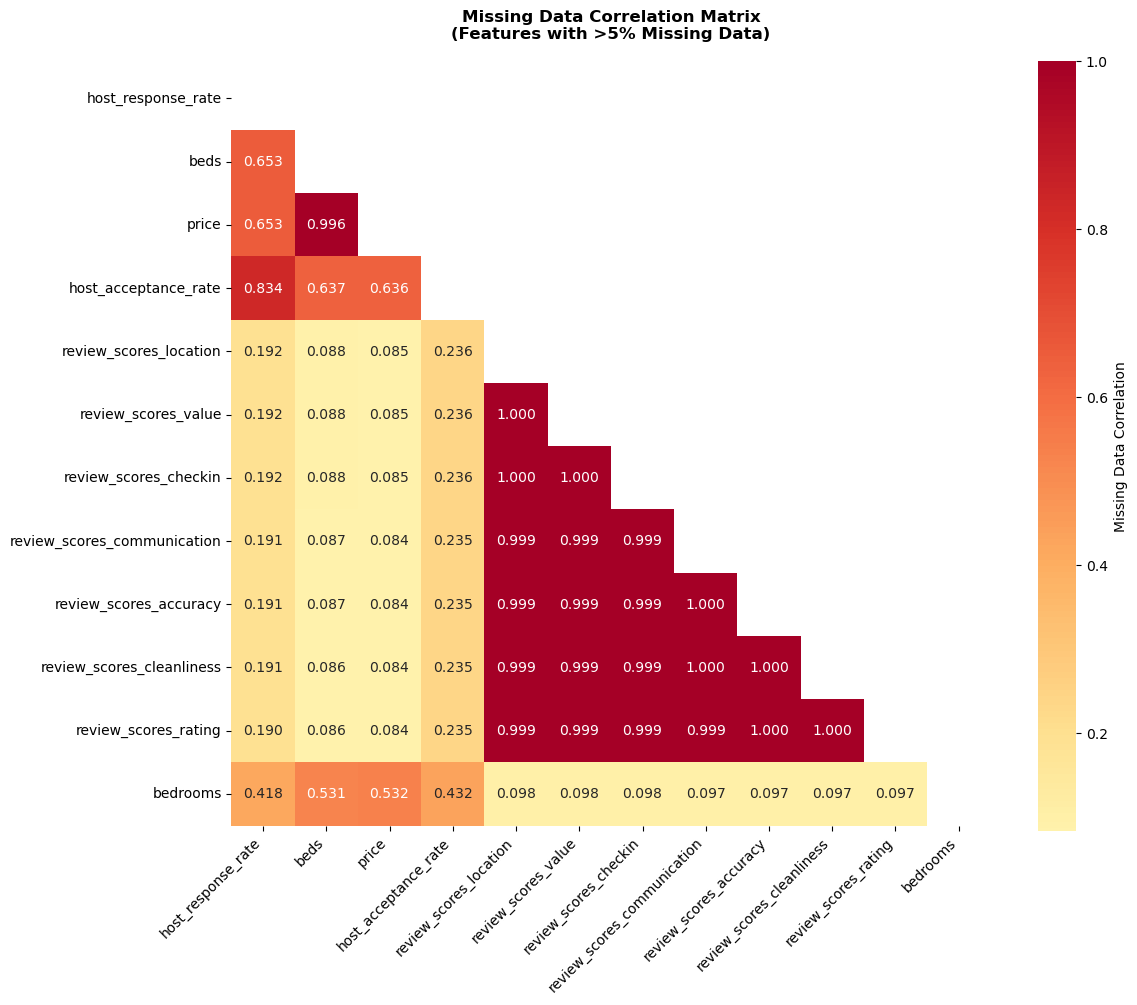


🔍 STRONG MISSING DATA CORRELATIONS (|r| > 0.3):
  • review_scores_value ↔ review_scores_checkin: r = 1.000
  • review_scores_location ↔ review_scores_value: r = 1.000
  • review_scores_location ↔ review_scores_checkin: r = 1.000
  • review_scores_accuracy ↔ review_scores_cleanliness: r = 1.000
  • review_scores_communication ↔ review_scores_accuracy: r = 1.000
  • review_scores_cleanliness ↔ review_scores_rating: r = 1.000
  • review_scores_communication ↔ review_scores_cleanliness: r = 1.000
  • review_scores_accuracy ↔ review_scores_rating: r = 1.000
  • review_scores_value ↔ review_scores_communication: r = 0.999
  • review_scores_checkin ↔ review_scores_communication: r = 0.999
  • review_scores_location ↔ review_scores_communication: r = 0.999
  • review_scores_communication ↔ review_scores_rating: r = 0.999
  • review_scores_value ↔ review_scores_accuracy: r = 0.999
  • review_scores_checkin ↔ review_scores_accuracy: r = 0.999
  • review_scores_location ↔ review_scores_accuracy:

In [17]:
# Focus on features with substantial missing data for correlation analysis
substantial_missing_features = critical_missing_df[
    critical_missing_df["missing_percentage"] > 5
]["feature"].tolist()

if len(substantial_missing_features) > 1:
    print(f"🔗 MISSING DATA CORRELATION ANALYSIS")
    print(
        f"Analyzing correlations between {len(substantial_missing_features)} features with >5% missing data"
    )
    print("=" * 60)

    # Create missing data indicator matrix
    missing_indicators = listings_df[substantial_missing_features].isnull().astype(int)

    # Calculate correlation matrix
    correlation_matrix = missing_indicators.corr()

    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Hide upper triangle

    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        fmt=".3f",
        cmap="RdYlBu_r",
        center=0,
        square=True,
        cbar_kws={"label": "Missing Data Correlation"},
    )
    plt.title(
        "Missing Data Correlation Matrix\n(Features with >5% Missing Data)",
        fontweight="bold",
        pad=20,
    )
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    # Save the correlation heatmap
    save_plot("02_missing_data_correlation_matrix", "Missing Data Correlation Matrix")
    plt.show()

    # Identify strong correlations
    strong_correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.3:  # Threshold for "strong" correlation
                strong_correlations.append(
                    {
                        "feature_1": correlation_matrix.columns[i],
                        "feature_2": correlation_matrix.columns[j],
                        "correlation": corr_val,
                    }
                )

    if strong_correlations:
        print("\n🔍 STRONG MISSING DATA CORRELATIONS (|r| > 0.3):")
        for corr in sorted(
            strong_correlations, key=lambda x: abs(x["correlation"]), reverse=True
        ):
            print(
                f"  • {corr['feature_1']} ↔ {corr['feature_2']}: r = {corr['correlation']:.3f}"
            )
    else:
        print("\n✅ No strong correlations found between missing data patterns")

else:
    print(
        "⚠️ Not enough features with substantial missing data for correlation analysis"
    )

## 6. Advanced Missing Data Visualization with missingno

🎨 ADVANCED MISSING DATA VISUALIZATIONS
Visualizing missing patterns for 22 features...

1. Missing Data Matrix - Shows location of missing values
📊 Plot saved: Missing Data Matrix -> 03_missing_data_matrix.png
📊 Plot saved: Missing Data Matrix -> 03_missing_data_matrix.png


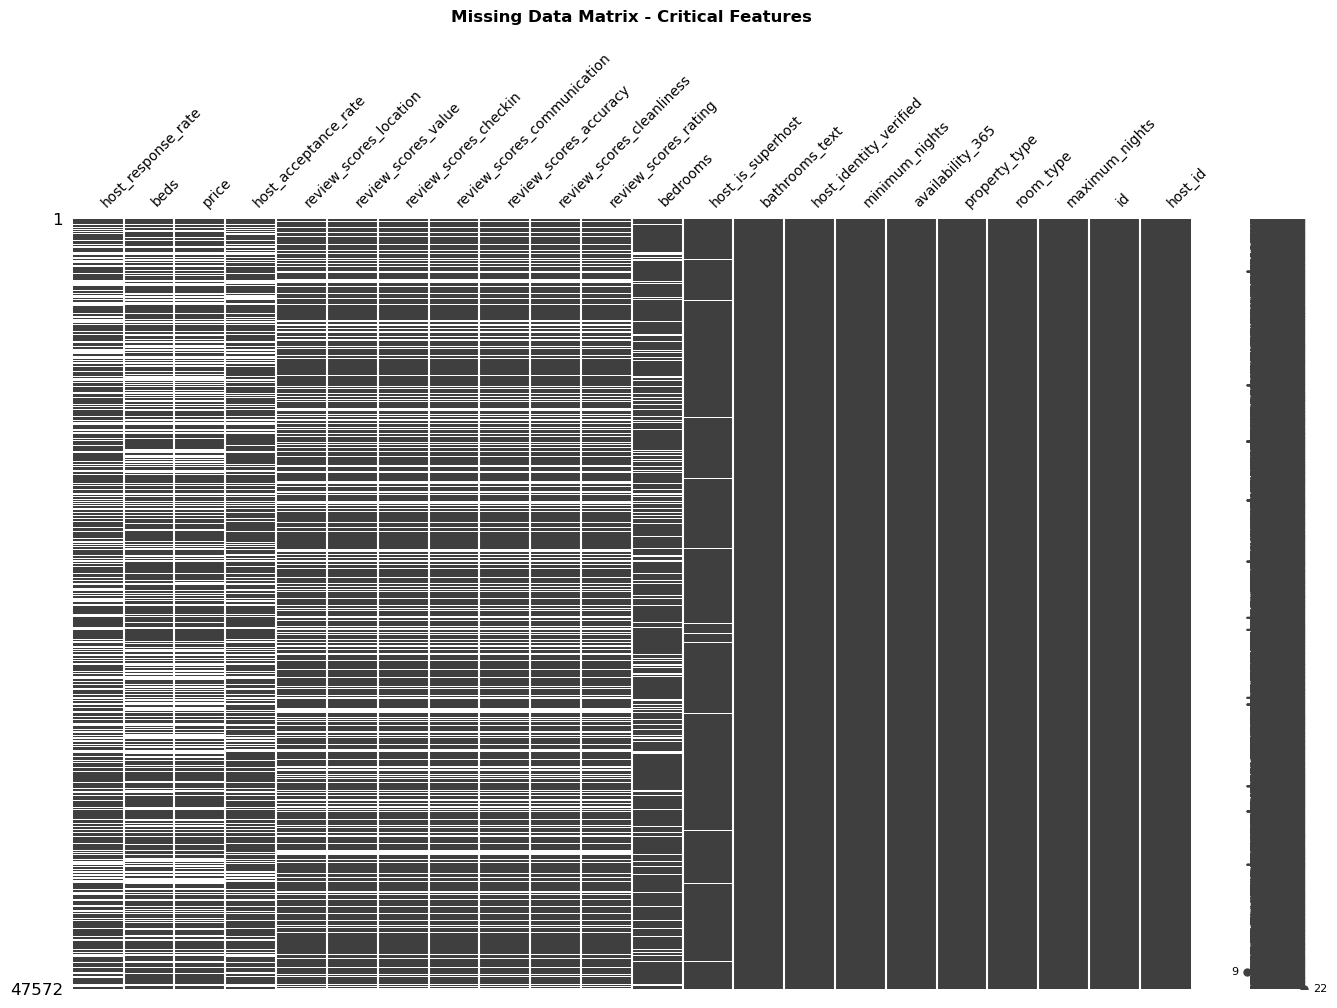


2. Missing Data Counts
📊 Plot saved: Missing Data Counts -> 04_missing_data_counts.png
📊 Plot saved: Missing Data Counts -> 04_missing_data_counts.png


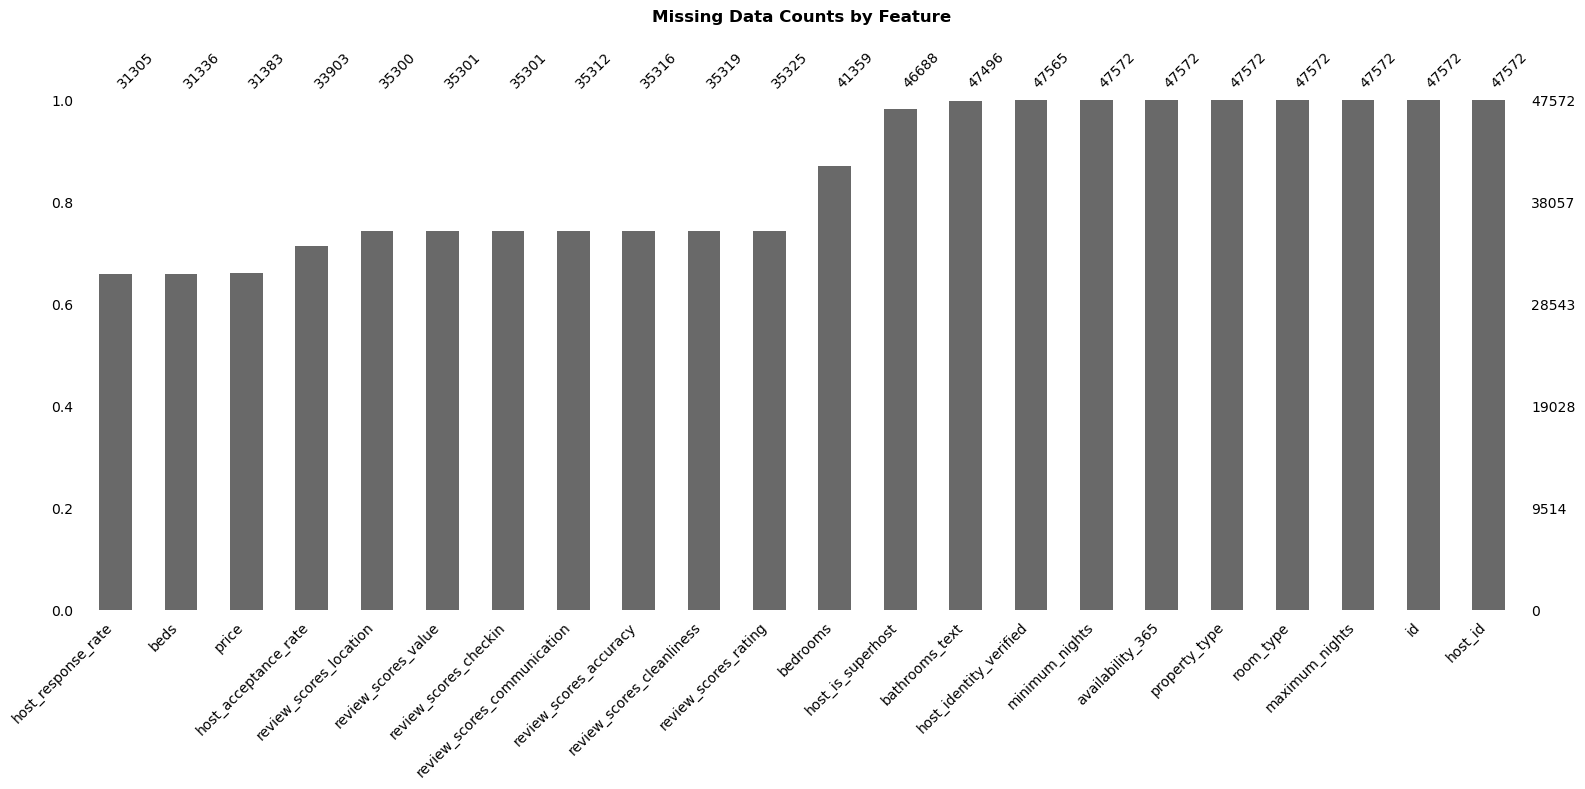


3. Missing Data Correlation Heatmap
📊 Plot saved: Missing Data Correlation Heatmap -> 05_missing_data_heatmap.png
📊 Plot saved: Missing Data Correlation Heatmap -> 05_missing_data_heatmap.png


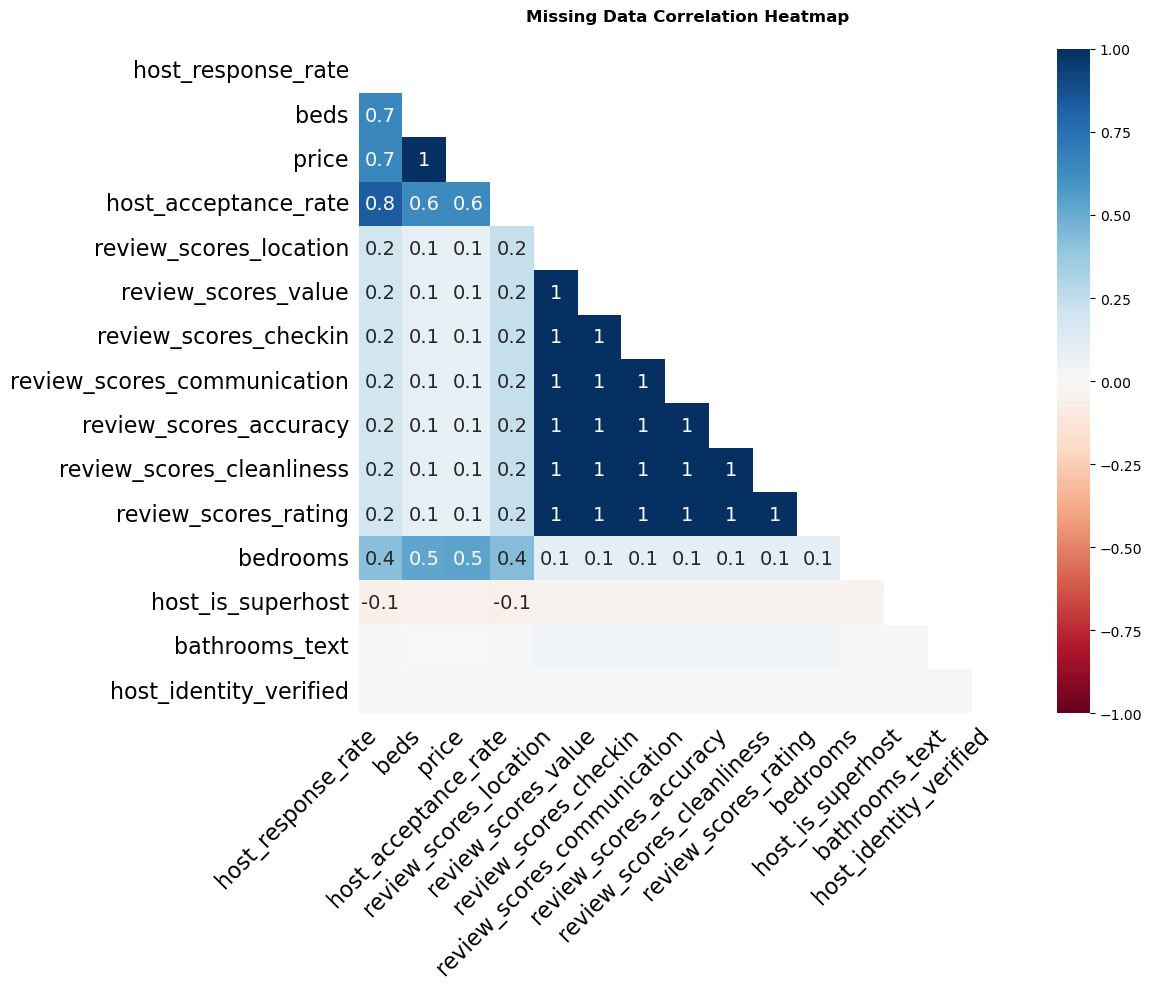


4. Missing Data Dendrogram - Shows clustering of missing patterns
📊 Plot saved: Missing Data Dendrogram -> 06_missing_data_dendrogram.png
📊 Plot saved: Missing Data Dendrogram -> 06_missing_data_dendrogram.png


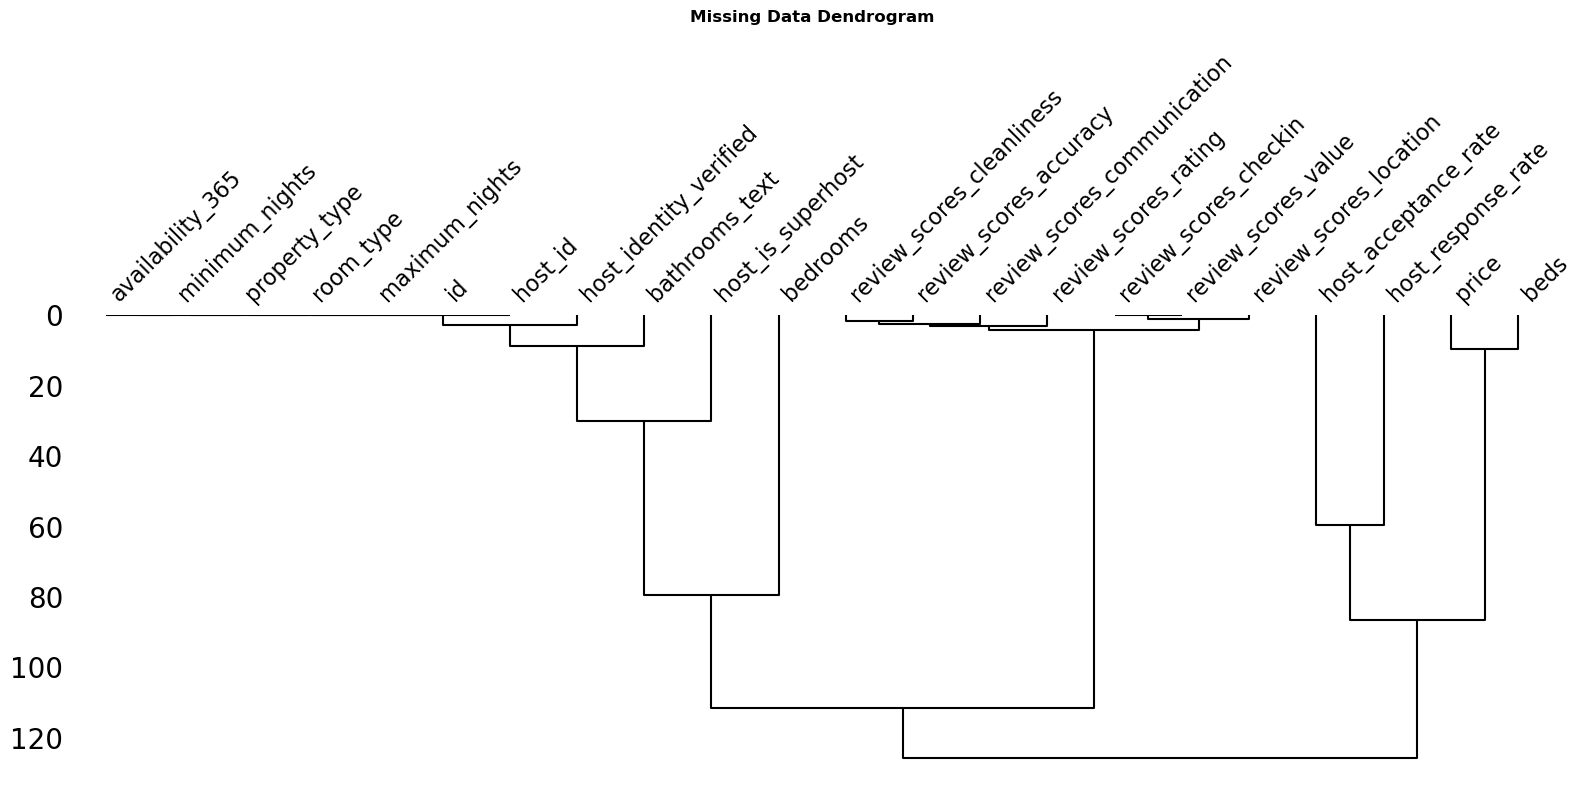

In [18]:
# Use missingno for advanced missing data visualizations
print("🎨 ADVANCED MISSING DATA VISUALIZATIONS")
print("=" * 50)

# Select subset of features for visualization (top missing + some complete ones for context)
viz_features = critical_missing_df.head(20)["feature"].tolist()

# Add some complete features for context
complete_features = ["id", "host_id", "property_type", "room_type"]
viz_features.extend([f for f in complete_features if f in listings_df.columns])

# Remove duplicates while preserving order
viz_features = list(dict.fromkeys(viz_features))

# Create subset for visualization
viz_df = listings_df[viz_features]

print(f"Visualizing missing patterns for {len(viz_features)} features...")

# 1. Missing data matrix
print("\n1. Missing Data Matrix - Shows location of missing values")
msno.matrix(viz_df, figsize=(16, 10), fontsize=10)
plt.title("Missing Data Matrix - Critical Features", fontweight="bold", pad=20)
plt.tight_layout()
# Save the matrix plot
save_plot("03_missing_data_matrix", "Missing Data Matrix")
plt.show()

# 2. Missing data bar chart
print("\n2. Missing Data Counts")
msno.bar(viz_df, figsize=(16, 8), fontsize=10)
plt.title("Missing Data Counts by Feature", fontweight="bold", pad=20)
plt.tight_layout()
# Save the bar chart
save_plot("04_missing_data_counts", "Missing Data Counts")
plt.show()

# 3. Missing data heatmap (correlation)
if len(viz_features) > 1:
    print("\n3. Missing Data Correlation Heatmap")
    msno.heatmap(viz_df, figsize=(12, 10))
    plt.title("Missing Data Correlation Heatmap", fontweight="bold", pad=20)
    plt.tight_layout()
    # Save the heatmap
    save_plot("05_missing_data_heatmap", "Missing Data Correlation Heatmap")
    plt.show()

# 4. Dendrogram (hierarchical clustering of missing patterns)
if len(viz_features) > 2:
    print("\n4. Missing Data Dendrogram - Shows clustering of missing patterns")
    try:
        msno.dendrogram(viz_df, figsize=(16, 8))
        plt.title("Missing Data Dendrogram", fontweight="bold", pad=20)
        plt.tight_layout()
        # Save the dendrogram
        save_plot("06_missing_data_dendrogram", "Missing Data Dendrogram")
        plt.show()
    except Exception as e:
        print(f"Could not create dendrogram: {e}")

## 7. Missing Data Impact on Price Analysis

Understanding how missing data relates to our target variable (price) is crucial for modeling decisions.

💰 MISSING DATA IMPACT ON PRICE ANALYSIS
Analyzing price impact for 28,692 listings (outliers removed)
Price range: $40 - $500

📊 Plot saved: Price Impact Analysis -> 07_price_impact_missing_data.png
📊 Plot saved: Price Impact Analysis -> 07_price_impact_missing_data.png


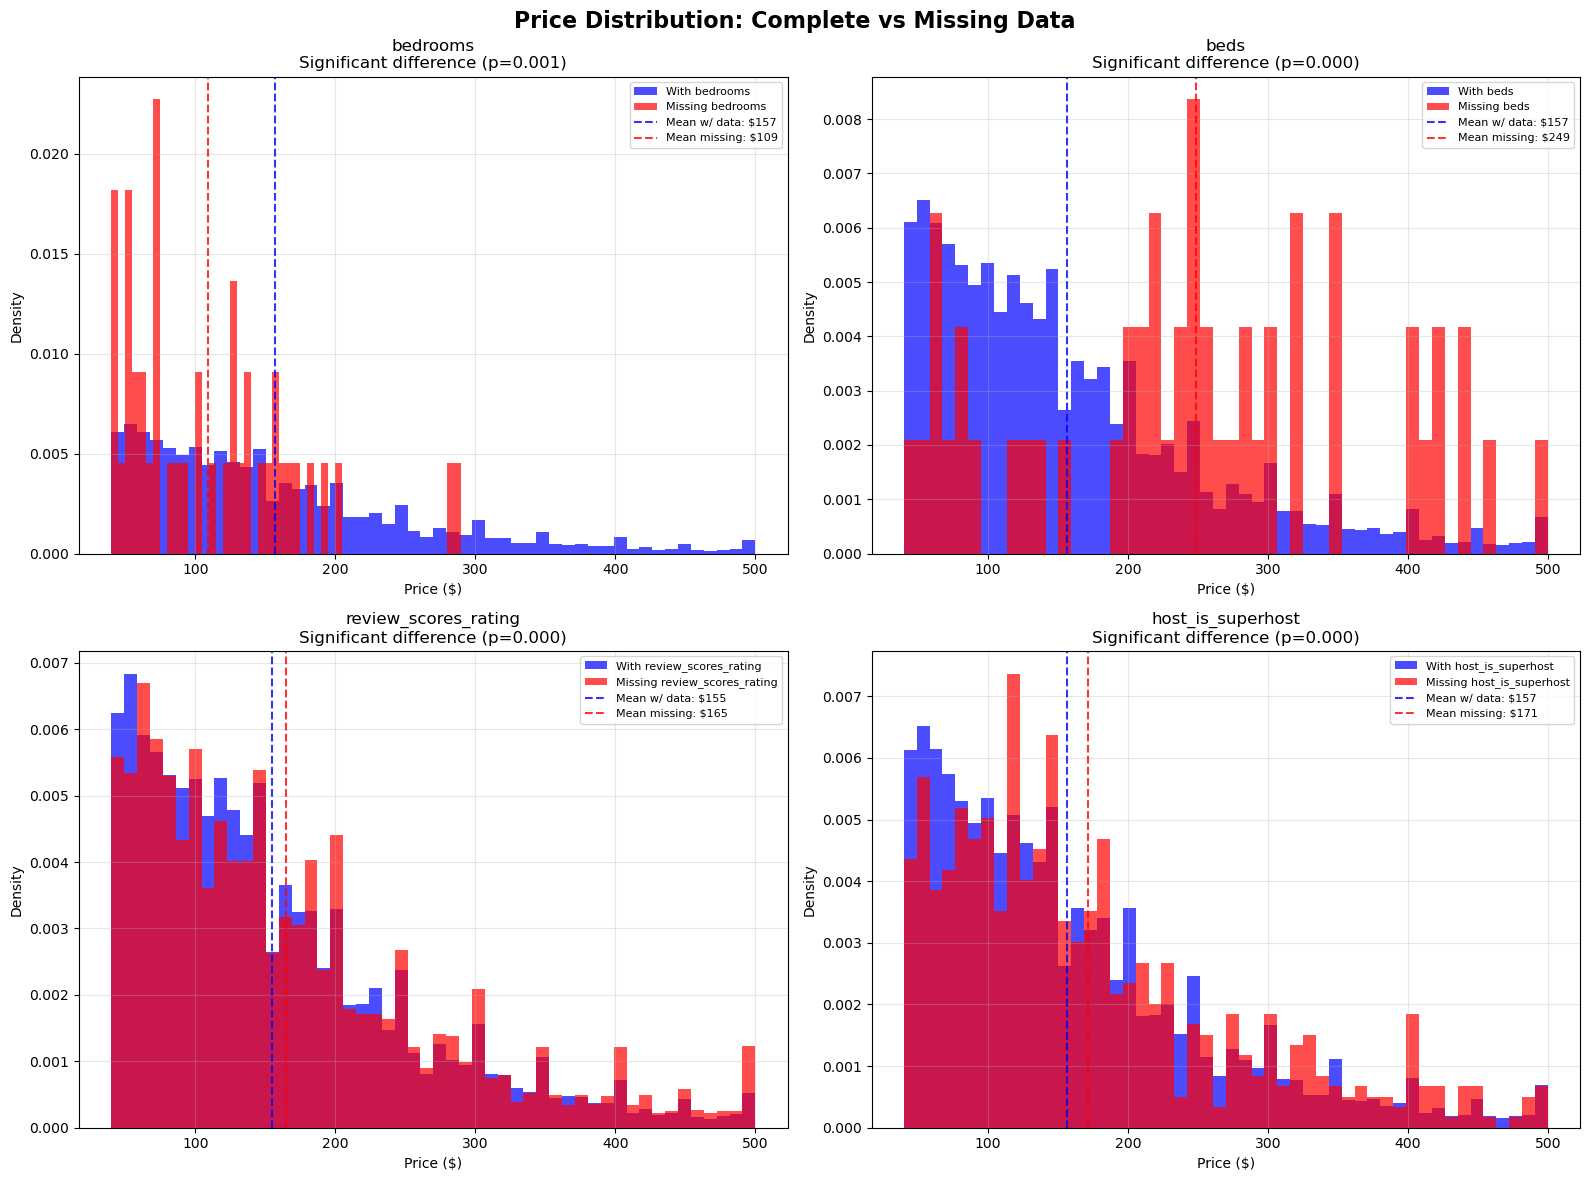


📊 PRICE IMPACT SUMMARY:
--------------------------------------------------------------------------------
Feature              Mean Diff    Median Diff  Significant? Sample Sizes   
--------------------------------------------------------------------------------
bedrooms             $     -48 $       -38 Yes          28,648/44      
beds                 $      92 $       114 Yes          28,640/52      
review_scores_rating $      10 $        10 Yes          22,240/6,452   
host_is_superhost    $      15 $        11 Yes          28,043/649     

💡 INTERPRETATION:
• Positive differences = listings with missing data have higher prices
• Negative differences = listings with missing data have lower prices
• Significant differences suggest missing data is not random (MAR/MNAR)


In [19]:
print("💰 MISSING DATA IMPACT ON PRICE ANALYSIS")
print("=" * 50)

# Ensure we have price data
if "price" in listings_df.columns:
    # Clean price data if needed
    if listings_df["price"].dtype == "object":
        listings_df["price_numeric"] = (
            listings_df["price"].astype(str).str.replace("$", "").str.replace(",", "")
        )
        listings_df["price_numeric"] = pd.to_numeric(
            listings_df["price_numeric"], errors="coerce"
        )
    else:
        listings_df["price_numeric"] = listings_df["price"]

    # Remove outliers for analysis (prices > 95th percentile or < 5th percentile)
    price_q05 = listings_df["price_numeric"].quantile(0.05)
    price_q95 = listings_df["price_numeric"].quantile(0.95)
    price_mask = (listings_df["price_numeric"] >= price_q05) & (
        listings_df["price_numeric"] <= price_q95
    )
    price_analysis_df = listings_df[price_mask].copy()

    print(
        f"Analyzing price impact for {len(price_analysis_df):,} listings (outliers removed)"
    )
    print(f"Price range: ${price_q05:.0f} - ${price_q95:.0f}\n")

    # Analyze how missing data affects price for key features
    key_features_for_price = [
        "bedrooms",
        "beds",
        "review_scores_rating",
        "host_is_superhost",
    ]
    available_features_for_price = [
        f for f in key_features_for_price if f in listings_df.columns
    ]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(
        "Price Distribution: Complete vs Missing Data", fontsize=16, fontweight="bold"
    )

    price_impact_results = []

    for i, feature in enumerate(available_features_for_price[:4]):
        row, col = i // 2, i % 2
        ax = axes[row, col]

        # Split data into missing vs not missing
        missing_mask = price_analysis_df[feature].isnull()
        price_with_data = price_analysis_df[~missing_mask]["price_numeric"].dropna()
        price_missing_data = price_analysis_df[missing_mask]["price_numeric"].dropna()

        if len(price_with_data) > 0 and len(price_missing_data) > 0:
            # Create histogram
            ax.hist(
                price_with_data,
                bins=50,
                alpha=0.7,
                label=f"With {feature}",
                density=True,
                color="blue",
            )
            ax.hist(
                price_missing_data,
                bins=50,
                alpha=0.7,
                label=f"Missing {feature}",
                density=True,
                color="red",
            )

            # Calculate statistics
            mean_with = price_with_data.mean()
            mean_missing = price_missing_data.mean()
            median_with = price_with_data.median()
            median_missing = price_missing_data.median()

            # Statistical test (Mann-Whitney U test for non-parametric comparison)
            from scipy.stats import mannwhitneyu

            try:
                statistic, p_value = mannwhitneyu(
                    price_with_data, price_missing_data, alternative="two-sided"
                )
                is_significant = p_value < 0.05
            except:
                p_value = None
                is_significant = False

            # Store results
            price_impact_results.append(
                {
                    "feature": feature,
                    "mean_with_data": mean_with,
                    "mean_missing": mean_missing,
                    "median_with_data": median_with,
                    "median_missing": median_missing,
                    "mean_difference": mean_missing - mean_with,
                    "median_difference": median_missing - median_with,
                    "p_value": p_value,
                    "is_significant": is_significant,
                    "count_with_data": len(price_with_data),
                    "count_missing": len(price_missing_data),
                }
            )

            ax.axvline(
                mean_with,
                color="blue",
                linestyle="--",
                alpha=0.8,
                label=f"Mean w/ data: ${mean_with:.0f}",
            )
            ax.axvline(
                mean_missing,
                color="red",
                linestyle="--",
                alpha=0.8,
                label=f"Mean missing: ${mean_missing:.0f}",
            )

            ax.set_xlabel("Price ($)")
            ax.set_ylabel("Density")
            ax.set_title(
                f"{feature}\n{'Significant' if is_significant else 'Not significant'} difference (p={p_value:.3f})"
                if p_value
                else feature
            )
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
        else:
            ax.text(
                0.5,
                0.5,
                f"Insufficient data\nfor {feature}",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            ax.set_title(feature)

    plt.tight_layout()
    # Save the price impact analysis plot
    save_plot("07_price_impact_missing_data", "Price Impact Analysis")
    plt.show()

    # Summary of price impact analysis
    if price_impact_results:
        print("\n📊 PRICE IMPACT SUMMARY:")
        print("-" * 80)
        print(
            f"{'Feature':<20} {'Mean Diff':<12} {'Median Diff':<12} {'Significant?':<12} {'Sample Sizes':<15}"
        )
        print("-" * 80)

        for result in price_impact_results:
            sig_text = "Yes" if result["is_significant"] else "No"
            sizes = f"{result['count_with_data']:,}/{result['count_missing']:,}"
            print(
                f"{result['feature']:<20} ${result['mean_difference']:>8.0f} ${result['median_difference']:>10.0f} {sig_text:<12} {sizes:<15}"
            )

        print("\n💡 INTERPRETATION:")
        print("• Positive differences = listings with missing data have higher prices")
        print("• Negative differences = listings with missing data have lower prices")
        print("• Significant differences suggest missing data is not random (MAR/MNAR)")

else:
    print("⚠️ Price column not found - skipping price impact analysis")

## 8. Geographic Missing Data Analysis

In [20]:
print("🗺️ GEOGRAPHIC MISSING DATA ANALYSIS")
print("=" * 50)

# Check if we have geographic data
geo_features = ["neighbourhood_cleansed", "latitude", "longitude"]
available_geo_features = [f for f in geo_features if f in listings_df.columns]

if len(available_geo_features) >= 2:
    print(f"Analyzing geographic completeness for: {', '.join(available_geo_features)}")

    # Geographic completeness analysis
    geo_completeness = []
    for feature in available_geo_features:
        complete_count = listings_df[feature].count()
        completeness_pct = (complete_count / len(listings_df)) * 100
        geo_completeness.append(
            {
                "feature": feature,
                "complete_count": complete_count,
                "completeness_pct": completeness_pct,
            }
        )

    # If we have coordinates, analyze missing neighbourhood data
    if (
        "latitude" in available_geo_features
        and "longitude" in available_geo_features
        and "neighbourhood_cleansed" in available_geo_features
    ):
        # Listings with coordinates but missing neighbourhood
        has_coords = listings_df["latitude"].notna() & listings_df["longitude"].notna()
        missing_neighbourhood = listings_df["neighbourhood_cleansed"].isna()

        coords_but_no_neighbourhood = has_coords & missing_neighbourhood

        print(f"\n🎯 COORDINATE vs NEIGHBOURHOOD ANALYSIS:")
        print(f"  • Total listings: {len(listings_df):,}")
        print(
            f"  • With coordinates: {has_coords.sum():,} ({has_coords.mean() * 100:.1f}%)"
        )
        print(
            f"  • With neighbourhood: {(~missing_neighbourhood).sum():,} ({(~missing_neighbourhood).mean() * 100:.1f}%)"
        )
        print(
            f"  • With coords but missing neighbourhood: {coords_but_no_neighbourhood.sum():,} ({coords_but_no_neighbourhood.mean() * 100:.1f}%)"
        )

        # Visualize geographic data completeness
        if coords_but_no_neighbourhood.sum() > 0:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Map of all listings
            complete_geo = listings_df[has_coords & ~missing_neighbourhood]
            incomplete_geo = listings_df[coords_but_no_neighbourhood]

            if len(complete_geo) > 0:
                axes[0].scatter(
                    complete_geo["longitude"],
                    complete_geo["latitude"],
                    alpha=0.5,
                    s=1,
                    color="blue",
                    label="Complete geographic data",
                )

            if len(incomplete_geo) > 0:
                axes[0].scatter(
                    incomplete_geo["longitude"],
                    incomplete_geo["latitude"],
                    alpha=0.8,
                    s=3,
                    color="red",
                    label="Missing neighbourhood",
                )

            axes[0].set_xlabel("Longitude")
            axes[0].set_ylabel("Latitude")
            axes[0].set_title("Geographic Data Completeness Map")
            axes[0].legend()
            axes[0].grid(alpha=0.3)

            # Geographic completeness summary
            geo_summary = pd.DataFrame(geo_completeness)
            bars = axes[1].bar(
                geo_summary["feature"],
                geo_summary["completeness_pct"],
                color=[
                    "green" if x > 95 else "orange" if x > 80 else "red"
                    for x in geo_summary["completeness_pct"]
                ],
            )
            axes[1].set_ylabel("Completeness (%)")
            axes[1].set_title("Geographic Features Completeness")
            axes[1].set_ylim(0, 100)

            # Add percentage labels on bars
            for bar, pct in zip(bars, geo_summary["completeness_pct"]):
                axes[1].text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 1,
                    f"{pct:.1f}%",
                    ha="center",
                    va="bottom",
                )

            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            # Save the geographic analysis plot
            save_plot(
                "08_geographic_missing_data_analysis",
                "Geographic Missing Data Analysis",
            )
            plt.show()

            print(f"\n💡 GEOGRAPHIC INSIGHTS:")
            if coords_but_no_neighbourhood.sum() > 100:
                print(
                    f"  • {coords_but_no_neighbourhood.sum():,} listings have coordinates but missing neighbourhood"
                )
                print(f"  • These could be imputed using reverse geocoding")
            else:
                print(f"  • Geographic data is relatively complete")

    # Neighbourhood missing value patterns
    if "neighbourhood_cleansed" in available_geo_features:
        neighbourhood_missing = listings_df["neighbourhood_cleansed"].isna().sum()
        neighbourhood_missing_pct = (neighbourhood_missing / len(listings_df)) * 100

        if neighbourhood_missing > 0:
            print(f"\n🏘️ NEIGHBOURHOOD ANALYSIS:")
            print(
                f"  • Missing neighbourhood data: {neighbourhood_missing:,} ({neighbourhood_missing_pct:.1f}%)"
            )

            # Top neighbourhoods (for context)
            top_neighbourhoods = (
                listings_df["neighbourhood_cleansed"].value_counts().head(10)
            )
            print(f"  • Most common neighbourhoods:")
            for neighbourhood, count in top_neighbourhoods.items():
                pct = (count / len(listings_df)) * 100
                print(f"    - {neighbourhood}: {count:,} ({pct:.1f}%)")

else:
    print("⚠️ Insufficient geographic features for analysis")

🗺️ GEOGRAPHIC MISSING DATA ANALYSIS
Analyzing geographic completeness for: neighbourhood_cleansed, latitude, longitude

🎯 COORDINATE vs NEIGHBOURHOOD ANALYSIS:
  • Total listings: 47,572
  • With coordinates: 47,572 (100.0%)
  • With neighbourhood: 47,572 (100.0%)
  • With coords but missing neighbourhood: 0 (0.0%)


## 10. Save Analysis Results

Save key findings for use in modeling pipeline.

In [22]:
# Save analysis results
output_dir = Path("../reports/missing_values_analysis")
output_dir.mkdir(exist_ok=True)

print("💾 SAVING ANALYSIS RESULTS")
print("=" * 40)

# Save critical features missing analysis
critical_missing_df.to_csv(
    output_dir / "critical_features_missing_analysis.csv", index=False
)
print(f"✅ Saved: critical_features_missing_analysis.csv")

# Save recommendations
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv(output_dir / "imputation_recommendations.csv", index=False)
print(f"✅ Saved: imputation_recommendations.csv")

# Save overall missing statistics
overall_stats = []
for name, stats in missing_stats.items():
    overall_stats.append(
        {
            "dataset": name,
            "total_columns": stats["total_columns"],
            "columns_with_missing": stats["columns_with_missing"],
            "overall_missing_pct": stats["overall_missing_pct"],
        }
    )

overall_stats_df = pd.DataFrame(overall_stats)
overall_stats_df.to_csv(output_dir / "dataset_missing_overview.csv", index=False)
print(f"✅ Saved: dataset_missing_overview.csv")

# Save price impact analysis if available
if "price_impact_results" in locals() and price_impact_results:
    price_impact_df = pd.DataFrame(price_impact_results)
    price_impact_df.to_csv(output_dir / "price_impact_analysis.csv", index=False)
    print(f"✅ Saved: price_impact_analysis.csv")

print(f"\n📁 All results saved to: {output_dir}")

# Summary of saved plots
print(f"\n🎨 PLOTS SAVED SUMMARY")
print("=" * 40)
saved_plots = list(plots_dir.glob("*.png"))
plot_descriptions = {
    "01_comprehensive_missing_data_analysis": "Overview of missing data patterns across critical features",
    "02_missing_data_correlation_matrix": "Correlation between missing data patterns",
    "03_missing_data_matrix": "Visual matrix showing missing data locations",
    "04_missing_data_counts": "Bar chart of missing data counts by feature",
    "05_missing_data_heatmap": "Heatmap showing missing data correlations",
    "06_missing_data_dendrogram": "Hierarchical clustering of missing patterns",
    "07_price_impact_missing_data": "Analysis of how missing data affects price",
    "08_geographic_missing_data_analysis": "Geographic patterns in missing data",
}

for i, plot_path in enumerate(sorted(saved_plots), 1):
    plot_stem = plot_path.stem
    description = plot_descriptions.get(plot_stem, "Missing data visualization")
    print(f"{i:2d}. {plot_stem.replace('_', ' ').title()}")
    print(f"    └─ {description}")

print(f"\n📊 Total plots saved: {len(saved_plots)}")
print(f"📁 Plots directory: {plots_dir}")
print(f"📁 CSV results directory: {output_dir}")

# Create a simple index file for easy reference
index_content = []
index_content.append("# Missing Values Analysis - Visualization Index")
index_content.append(
    f"\nGenerated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}"
)
index_content.append(f"\nTotal plots: {len(saved_plots)}")
index_content.append("\n## Saved Plots:\n")

for i, plot_path in enumerate(sorted(saved_plots), 1):
    plot_stem = plot_path.stem
    description = plot_descriptions.get(plot_stem, "Missing data visualization")
    index_content.append(
        f"{i}. **{plot_stem.replace('_', ' ').title()}** (`{plot_path.name}`)"
    )
    index_content.append(f"   - {description}\n")

# Save index file
index_path = plots_dir / "README.md"
with open(index_path, "w") as f:
    f.write("\n".join(index_content))

print(f"📝 Plot index saved: {index_path.name}")

print(f"\n🎉 Missing Values Analysis Complete!")
print(f"\nKey insights:")
print(
    f"• {len(critical_missing_df[critical_missing_df['priority'] == 'HIGH'])} features need immediate attention (>20% missing)"
)
print(f"• Geographic features can be improved with reverse geocoding")
print(
    f"• Review features missing likely indicates 'no reviews' - domain-specific handling needed"
)
print(
    f"• Most features have <20% missingness and can use standard imputation techniques"
)

💾 SAVING ANALYSIS RESULTS
✅ Saved: critical_features_missing_analysis.csv
✅ Saved: imputation_recommendations.csv
✅ Saved: dataset_missing_overview.csv
✅ Saved: price_impact_analysis.csv

📁 All results saved to: ../reports/missing_values_analysis

🎨 PLOTS SAVED SUMMARY
 1. 01 Comprehensive Missing Data Analysis
    └─ Overview of missing data patterns across critical features
 2. 02 Missing Data Correlation Matrix
    └─ Correlation between missing data patterns
 3. 03 Missing Data Matrix
    └─ Visual matrix showing missing data locations
 4. 04 Missing Data Counts
    └─ Bar chart of missing data counts by feature
 5. 05 Missing Data Heatmap
    └─ Heatmap showing missing data correlations
 6. 06 Missing Data Dendrogram
    └─ Hierarchical clustering of missing patterns
 7. 07 Price Impact Missing Data
    └─ Analysis of how missing data affects price

📊 Total plots saved: 7
📁 Plots directory: ../reports/figures/missing_values_analysis
📁 CSV results directory: ../reports/missing_valu

## Conclusion

This comprehensive missing values analysis provides:

1. **Complete landscape** of missing data across all datasets
2. **Feature-specific strategies** for imputation based on missingness patterns
3. **Priority framework** for implementation
4. **Impact analysis** showing how missing data relates to price
5. **Actionable recommendations** for the modeling pipeline

**Key Findings:**
- Most critical features have manageable missingness (<20%)
- Geographic data can be improved through reverse geocoding
- Review features need domain-specific handling
- Some high-missingness features may need to be dropped or used as indicators

**Next Steps:**
1. Implement reverse geocoding for neighbourhood_cleansed
2. Create missing indicators for high-missingness features
3. Apply domain-specific imputation strategies
4. Validate imputation impact on model performance